# Linear Regression Analysis

In this file we will be continuing our analysis of the housing dataset. In order to improve the model there will be a few additional changes to the EDA process, as well as an analysis of the features to move down the number of features involved. Finally, there will be a different model trained.

In [1]:
# Import the nessesary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import PredictionError
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
!wget https://raw.githubusercontent.com/hixtape1212/Group1Capstone/Gerardo/Austin_notebooks/austinHousingData.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
file_path = 'Austin_notebooks/austinHousingData.csv'
df = pd.read_csv(file_path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15171 entries, 0 to 15170
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   zpid                        15171 non-null  int64  
 1   city                        15171 non-null  object 
 2   streetAddress               15171 non-null  object 
 3   zipcode                     15171 non-null  int64  
 4   description                 15171 non-null  object 
 5   latitude                    15171 non-null  float64
 6   longitude                   15171 non-null  float64
 7   propertyTaxRate             15171 non-null  float64
 8   garageSpaces                15171 non-null  int64  
 9   hasAssociation              15171 non-null  bool   
 10  hasCooling                  15171 non-null  bool   
 11  hasGarage                   15171 non-null  bool   
 12  hasHeating                  15171 non-null  bool   
 13  hasSpa                      151

In [5]:
#Let's look at the home types. We primarily only want single family homes
df.homeType.value_counts()

Single Family            14241
Condo                      470
Townhouse                  174
Multiple Occupancy          96
Vacant Land                 83
Residential                 37
Apartment                   37
Mobile / Manufactured       17
MultiFamily                 10
Other                        6
Name: homeType, dtype: int64

In [6]:
df = df[df.homeType == 'Single Family']
df.shape

(14241, 47)

In [7]:
#Drop object columns as well as zipid
col_drop_list = df.select_dtypes(include=[np.object]).keys()
col_drop_list = col_drop_list.union(['zpid'])
df = df.drop(col_drop_list, axis=1)
df.shape

C:\Users\gyanezarvizu\AppData\Local\Temp\ipykernel_24940\1663181986.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  col_drop_list = df.select_dtypes(include=[np.object]).keys()


(14241, 39)

In [8]:
#Changing Booleans to int values
col_bool_list = ['hasAssociation', 'hasCooling',
                 'hasGarage', 'hasHeating', 'hasSpa', 'hasView']

for col in col_bool_list:
    name = col + '_int'
    df[name] = df[col].astype(int)

df = df.drop(col_bool_list, axis=1)
df.shape

(14241, 39)

In [9]:
#Lets look at the home prices we are predicting
df.describe().transpose().apply(lambda x: x.apply('{0:f}'.format))

,count,mean,std,min,25%,50%,75%,max
zipcode,14241.000000,78736.186785,18.721340,78617.000000,78727.000000,78739.000000,78749.000000,78759.000000
latitude,14241.000000,30.291740,0.098383,30.085030,30.201195,30.284163,30.367920,30.517174
longitude,14241.000000,-97.780411,0.085880,-98.022057,-97.841804,-97.771988,-97.718689,-97.569504
propertyTaxRate,14241.000000,1.994731,0.054207,1.980000,1.980000,1.980000,1.980000,2.210000
garageSpaces,14241.000000,1.236851,1.343474,0.000000,0.000000,1.000000,2.000000,20.000000
parkingSpaces,14241.000000,1.236219,1.343612,0.000000,0.000000,1.000000,2.000000,20.000000
yearBuilt,14241.000000,1988.408749,21.555337,1905.000000,1974.000000,1993.000000,2006.000000,2020.000000
latestPrice,14241.000000,516387.884629,446969.176124,5500.000000,310000.000000,409900.000000,575000.000000,13500000.000000
numPriceChanges,14241.000000,3.044730,2.491960,1.000000,1.000000,2.000000,4.000000,23.000000
latest_salemonth,14241.000000,6.728039,3.134325,1.000000,4.000000,7.000000,9.000000,12.000000


From the previous table the price ranges wildly between 5500 and 13Milion. Now let's see the plot.

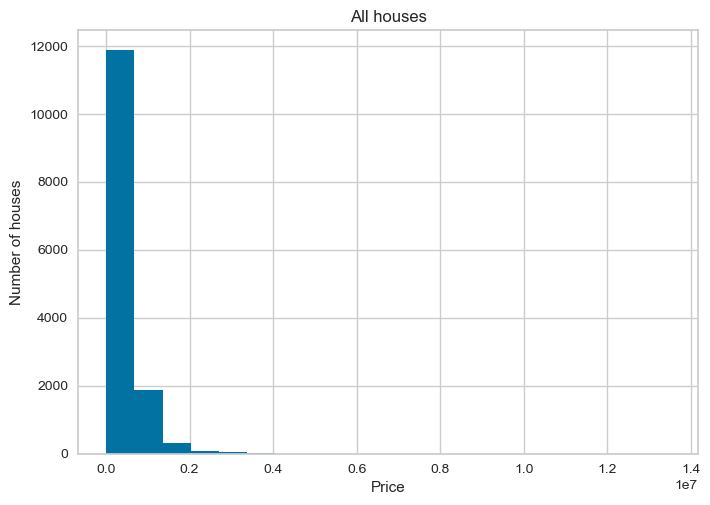

In [10]:
# Plot latestPrice distribution
plt.hist(df['latestPrice'], bins=20)
plt.xlabel('Price')
plt.ylabel('Number of houses')
plt.title('All houses')
plt.show()

In [11]:
#Narrowing this down can help our model. Lets look at the mid 5 & 95%
upper = np.percentile(df.latestPrice, 95)
lower = np.percentile(df.latestPrice, 5)

print('Middle 90 are values between {} and {}'.format(lower, upper))

Middle 90 are values between 207000.0 and 1175000.0


The middle 95% of the home values are between 207,000 and 1,175,000. If we move the lower bound down I think we should be looking at home from 200,000 to 1.1 million, covering roughly 95% of our data

In [12]:
df = df.drop(df[df['latestPrice'] < 200000].index)
df = df.drop(df[df['latestPrice'] > 1175000].index)
df.shape

(12907, 39)

## Analysis
We will start looking the correlation of variables with our dependen variable (latestPrice) and then we will see if we have a symmetric distribution.

#### Check correlation with latestPrice

In [13]:
df.corr()['latestPrice']

zipcode                      -0.188523
latitude                      0.114658
longitude                    -0.263563
propertyTaxRate              -0.068051
garageSpaces                  0.150064
parkingSpaces                 0.149677
yearBuilt                    -0.039928
latestPrice                   1.000000
numPriceChanges               0.034400
latest_salemonth              0.050514
latest_saleyear               0.068581
numOfPhotos                   0.172712
numOfAccessibilityFeatures    0.022540
numOfAppliances               0.042001
numOfParkingFeatures          0.096584
numOfPatioAndPorchFeatures    0.110987
numOfSecurityFeatures         0.078760
numOfWaterfrontFeatures       0.031016
numOfWindowFeatures           0.109137
numOfCommunityFeatures        0.004434
lotSizeSqFt                   0.039251
livingAreaSqFt                0.369748
numOfPrimarySchools          -0.173300
numOfElementarySchools        0.136677
numOfMiddleSchools            0.130154
numOfHighSchools         

We dont have multicollinearity

#### Display distribution

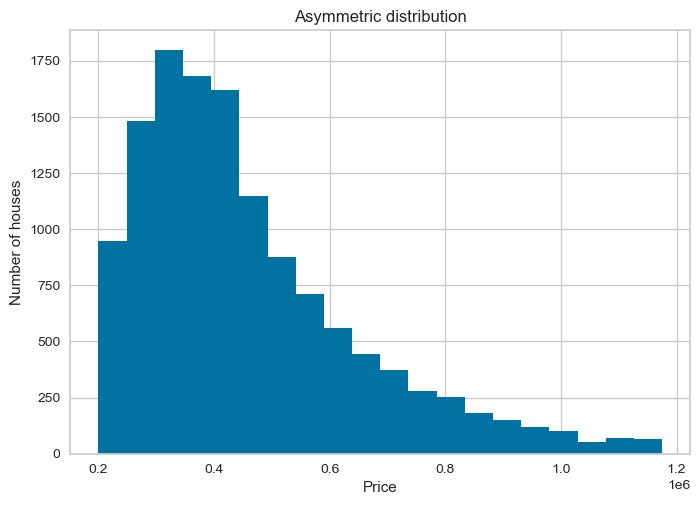

In [14]:
# Plot latestPrice distribution
plt.hist(df['latestPrice'], bins=20)
plt.xlabel('Price')
plt.ylabel('Number of houses')
plt.title('Asymmetric distribution')
plt.show()

We can see an asymmetric distribution and could apply a logarithmic function to deal with this

In [15]:
# Applying logarithmic funtion
transformer = FunctionTransformer(np.log1p, validate=True)
df_log = transformer.transform(df)

C:\Users\gyanezarvizu\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(
C:\Users\gyanezarvizu\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:205: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))


In [16]:
# Making a new dataframe with logarithmic data
columns_names = df.columns

df_log = pd.DataFrame(df_log, columns= columns_names)
df_log.head(3)

,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,parkingSpaces,yearBuilt,latestPrice,numPriceChanges,latest_salemonth,...,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,hasAssociation_int,hasCooling_int,hasGarage_int,hasHeating_int,hasSpa_int,hasView_int
0,11.272903,3.447783,NaN,1.091923,1.098612,1.098612,7.607381,12.628070,1.791759,2.302585,...,2.70805,1.386294,1.609438,1.098612,0.693147,0.693147,0.693147,0.693147,0.0,0.0
1,11.272903,3.447848,NaN,1.091923,1.098612,1.098612,7.607878,12.594734,0.693147,2.397895,...,2.70805,1.098612,1.609438,0.693147,0.693147,0.693147,0.693147,0.693147,0.0,0.0
2,11.272903,3.447118,NaN,1.091923,0.000000,0.000000,7.610358,12.453425,0.693147,2.079442,...,2.70805,1.098612,1.386294,0.693147,0.693147,0.693147,0.000000,0.693147,0.0,0.0


 Column 'longitude' has negative numbers, after applying the logarithmic function data became NaN, so we have to delete it

In [17]:
# Delete longitude column
df_log = df_log.drop('longitude', axis=1)
df.head(3)

,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,parkingSpaces,yearBuilt,latestPrice,numPriceChanges,latest_salemonth,...,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,hasAssociation_int,hasCooling_int,hasGarage_int,hasHeating_int,hasSpa_int,hasView_int
0,78660,30.430632,-97.663078,1.98,2,2,2012,305000,5,9,...,14,3.0,4,2,1,1,1,1,0,0
1,78660,30.432672,-97.661697,1.98,2,2,2013,295000,1,10,...,14,2.0,4,1,1,1,1,1,0,0
2,78660,30.409748,-97.639771,1.98,0,0,2018,256125,1,7,...,14,2.0,3,1,1,1,0,1,0,0


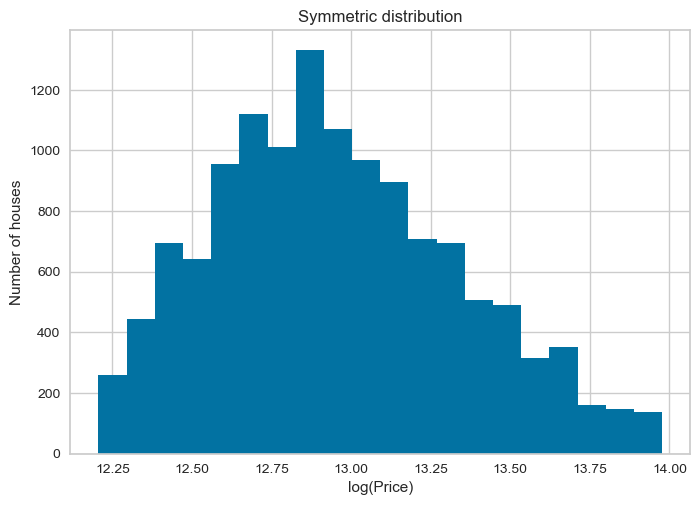

In [18]:
# Plot latestPrice distribution
plt.hist(df_log['latestPrice'], bins=20)
plt.xlabel('log(Price)')
plt.ylabel('Number of houses')
plt.title('Symmetric distribution')
plt.show()

#### Creating testing and training data

In [19]:
#Creating Train and Test splits
X = df_log.drop('latestPrice', axis='columns')
y = df_log.latestPrice
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.2,
                                                    random_state=42)

In [20]:
# Comparing size of X sets
print(X.shape, X_train.shape, X_test.shape)

(12907, 37) (10325, 37) (2582, 37)


## Lineal regression

In [21]:
# Creating the model
lr = LinearRegression()

In [22]:
# Get model results
lr.fit(X_train, y_train)

LinearRegression()

In [23]:
# Apply model in X_test
prediction_test_lr = lr.predict(X_test)

#### Evaluation

In [24]:
# MAE
print('Mean Absolute Error: {}'.format(round(mean_absolute_error(np.expm1(y_test), np.expm1(prediction_test_lr)), 3)))
# R^2
print('R^2: {}'.format(round(r2_score(y_test, prediction_test_lr), 3)))

Mean Absolute Error: 85867.172
R^2: 0.6


* Our model is off by about 85,867 dollars in a given prediction
* This model is explaining only the 60% of data

#### Plot
Comparison between the actual data from the dataset and the predicted values generated by our model.

C:\Users\gyanezarvizu\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


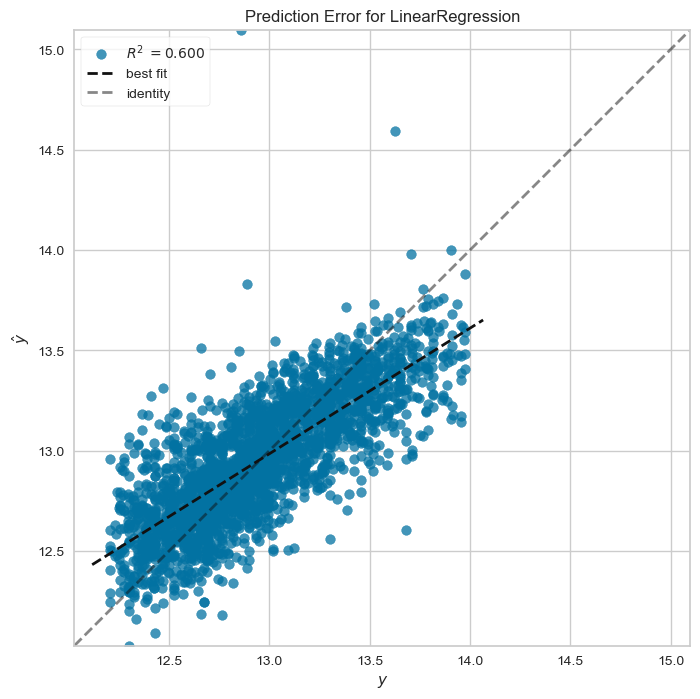

In [25]:
# Prediction Error for our model: 
fig, ax = plt.subplots(figsize=(8,8)) # size plot
visualizer = PredictionError(lr) # instantiate visualizer

visualizer.fit(X_train, y_train) # Fit training data to the visualizer
visualizer.score(X_test, y_test) # Evaluate the model on the test data
visualizer.show() # Finalize and render the figure
plt.show()

## Desicion tree

In [26]:
# Initializing model
dtr = DecisionTreeRegressor(random_state = 42, max_depth=9)

In [27]:
# Train model
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=9, random_state=42)

In [28]:
# Testing X_test
prediction_test_dtr = dtr.predict(X_test)

#### Evaluation

In [29]:
# MAE
print('Mean Absolute Error: {}'.format(round(mean_absolute_error(np.expm1(y_test), np.expm1(prediction_test_dtr)), 3)))
# R^2
print('R^2: {}'.format(round(r2_score(y_test, prediction_test_dtr), 3)))

Mean Absolute Error: 76000.787
R^2: 0.658


* Our model is off by about 76,000 dollars in a given prediction
* This model is explaining only the 65.8% of data

#### Plot
Comparison between the actual data from the dataset and the predicted values generated by our model.

C:\Users\gyanezarvizu\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


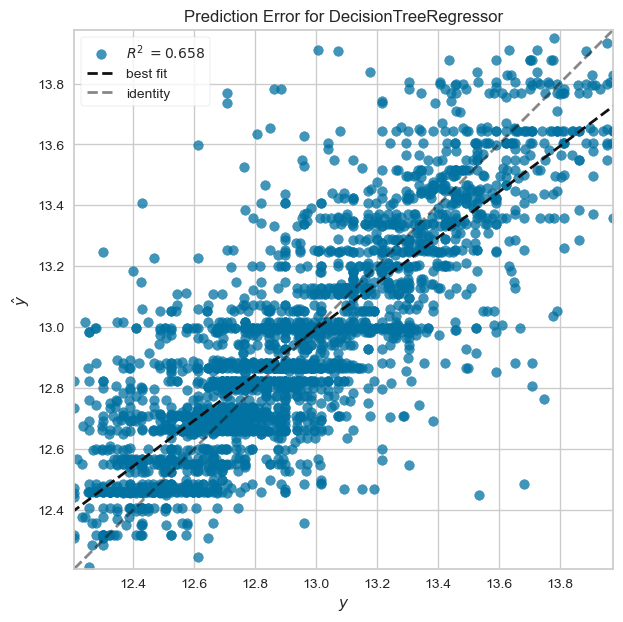

In [30]:
# Prediction Error for our model
fig, ax = plt.subplots(figsize=(7,7)) # size plot
visualizer = PredictionError(dtr) # instantiate visualizer

visualizer.fit(X_train, y_train) # Fit training data to the visualizer
visualizer.score(X_test, y_test) # Evaluate the model on the test data
visualizer.show() # Finalize and render the figure
plt.show()

#### Cross validation
Now to be sure that our model is not overfitting, we will apply cross validation with 5 splits.

In [31]:
# Split data in five slides
cv = KFold(n_splits = 5, shuffle = True)

#Apply cross validation
accuracy_cross_val_r2 = cross_val_score(estimator = dtr,
                                       X = X_train,
                                       y = y_train,
                                       scoring = 'r2',
                                       cv = cv)
print('Accuracy mean r2: {}'.format(round(accuracy_cross_val_r2.mean(), 3)))

Accuracy mean r2: 0.66


## Random forest

In [32]:
# Initializing model
rf = RandomForestRegressor(random_state=42, max_depth=9, n_estimators=50)

In [33]:
# Train model
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, n_estimators=50, random_state=42)

In [34]:
prediction_test_rf = rf.predict(X_test)

#### Evaluation

In [35]:
# MAE
print('Mean Absolute Error: {}'.format(round(mean_absolute_error(np.expm1(y_test), np.expm1(prediction_test_rf)), 3)))
# R^2
print('R^2: {}'.format(round(r2_score(y_test, prediction_test_rf), 3)))

Mean Absolute Error: 65611.698
R^2: 0.75


* Our model is off by about 65,611 dollars in a given prediction
* This model is explaining only the 75% of data

#### Plot
Comparison between the actual data from the dataset and the predicted values generated by our model.

C:\Users\gyanezarvizu\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


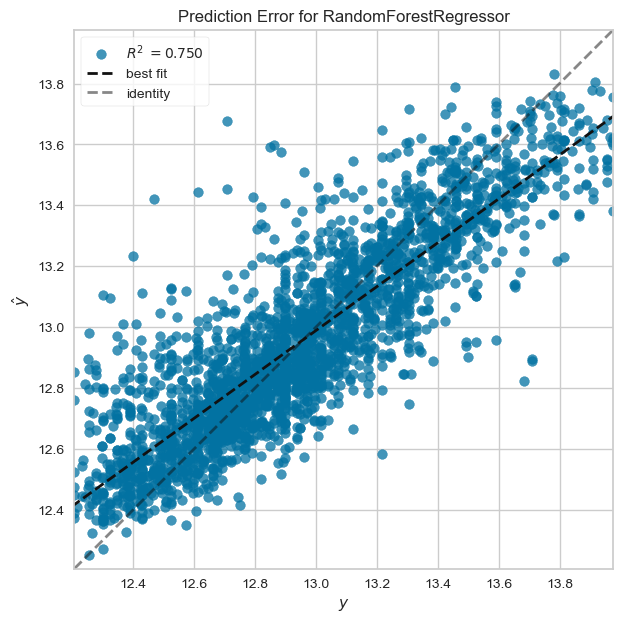

In [36]:
# Prediction Error for our model
fig, ax = plt.subplots(figsize=(7,7)) # size plot
visualizer = PredictionError(rf) # instantiate visualizer

visualizer.fit(X_train, y_train) # Fit training data to the visualizer
visualizer.score(X_test, y_test) # Evaluate the model on the test data
visualizer.show() # Finalize and render the figure
plt.show()

#### Cross validation
Now to be sure that our model is not overfitting, we will apply cross validation with 5 splits.

In [37]:
#Apply cross validation
accuracyRF_cross_val_r2 = cross_val_score(estimator = rf,
                                       X = X_train,
                                       y = y_train,
                                       scoring = 'r2',
                                       cv = cv)

print('Results: {}'.format(accuracyRF_cross_val_r2))
print('Mean R^2: {}'.format(round(accuracyRF_cross_val_r2.mean(), 3)))

Results: [0.76894677 0.75799053 0.75710962 0.77130077 0.7683893 ]
Mean R^2: 0.765


## XGBoost Regressor

In [38]:
#import xgboost as xgb
xgbr = XGBRegressor(random_state=42, max_depth=7, n_estimators=70)

In [39]:
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=70, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [40]:
prediction_test_xgbr = xgbr.predict(X_test)

#### Evaluation

In [41]:
# MAE
print('Mean Absolute Error: {}'.format(round(mean_absolute_error(np.expm1(y_test), np.expm1(prediction_test_xgbr)), 3)))
# R^2
print('R^2: {}'.format(round(r2_score(y_test, prediction_test_xgbr), 3)))

Mean Absolute Error: 59788.77
R^2: 0.78


* Our model is off by about 59,788 dollars in a given prediction
* This model is explaining only the 78% of data

#### Plot
Comparison between the actual data from the dataset and the predicted values generated by our model.

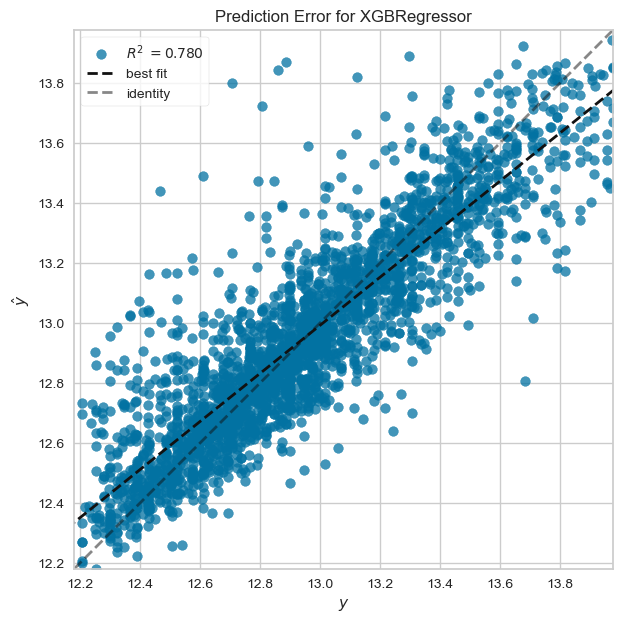

In [42]:
# Prediction Error for our model: XGBRegressor
fig, ax = plt.subplots(figsize=(7,7)) # size plot
visualizer = PredictionError(xgbr) # instantiate visualizer

visualizer.fit(X_train, y_train) # Fit training data to the visualizer
visualizer.score(X_test, y_test) # Evaluate the model on the test data
visualizer.show() # Finalize and render the figure
plt.show()

#### Cross validation
Now to be sure that our model is not overfitting, we will apply cross validation with 5 splits.

In [43]:
#Apply cross validation
accuracyXGBR_cross_val_r2 = cross_val_score(estimator = xgbr,
                                       X = X_train,
                                       y = y_train,
                                       scoring = 'r2',
                                       cv = cv)
print('Results: {}'.format(accuracyXGBR_cross_val_r2))
print('Mean R^2: {}'.format(round(accuracyXGBR_cross_val_r2.mean(), 3)))

Results: [0.78452278 0.80555776 0.79799082 0.80423107 0.79685172]
Mean R^2: 0.798


### In conclusion our better model with the best performance is XGBoost Regressor

##### Packages to install
* pip install -U yellowbrick
* pip install xgboost